In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# get all necessary python libraries to use during analysis

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import os
import itertools as _it
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from PythonUtilities.PyDBA.pydba import PyDBA, pd
from PythonUtilities.LoggingUtility import Logging

# from fancyimpute import KNN

#dba = PyDBA()
#con = dba.init_new_connection('DPHL-PROPSCORE', 'FSHeartbeat')



PyDBA BOOTING UP.
mssql+pymssql://DPHL-PROPSCORE/FSHeartbeat database exists.
New DPHL-PROPSCORE.FSHeartbeat connection successfully established.


In [3]:
# read in data and display the top rows
df = #dba.read_df('InvestorPersonaData', con) >>>>>>>Read in Excel file data here instead<<<<<<<
keep_cols = [
    'State', 'DateBecameRep_NumberOfYears', 'Title Categories', 'Advisory Producer:', 'Branch Type',
    'Total Sales: All Funds', 'AUM', 'First Sale Date: All Funds', 'Alt AUM', 'RegulatoryDisclosures', 'DuallyLicensedBDRIARep'
]

original_df = df.copy()

df = df[keep_cols].fillna(0)

df.columns = [
    'State', 'YearsInBusiness', 'Title Categories', 'Advisory Producer', 'Branch Type',
    'Total Sales: All Funds', 'AUM', 'YearsPartnering', 'Alt AUM', 'RegulatoryDisclosures', 'DuallyLicensedRep'
]


def calculate_percentile_ranks(frame, col_names, new_names=None, remove_original=True, bin_=True):
    if new_names is None:
        new_names = col_names
    
    for col in col_names:
        frame[new_names[col_names.index(col)]] = frame[col].rank(pct=True) * 100
#         if bin_:
#             frame[new_names[col_names.index(col)] + ' bin'] = pd.qcut(frame[new_names[col_names.index(col)]], 4, labels=False)
        if remove_original:
            del frame[col]
    return frame

df = calculate_percentile_ranks(df, ['Total Sales: All Funds', 'AUM', 'Alt AUM'], ['Sales Percentile', 'AUM Percentile', 'Alt AUM Percentile'])
df.head()

,State,YearsInBusiness,Title Categories,Advisory Producer,Branch Type,YearsPartnering,RegulatoryDisclosures,DuallyLicensedRep,Sales Percentile,AUM Percentile,Alt AUM Percentile
0,CA,40.0,Branch Manager,true,OSJ,2010-05-03,Yes,Yes,96.917138,77.372958,98.098990
1,NY,40.0,Unknown,false,Satellite,2011-08-01,Yes,Yes,98.339591,68.859394,47.165671
2,CA,50.0,Advisor,false,OSJ,2013-06-27,Yes,Yes,46.428005,93.495849,98.098990
3,CO,50.0,Advisor,false,OSJ,2017-03-13,Yes,No,3.064354,68.859394,47.165671
4,PA,46.0,Advisor,true,Satellite,2011-08-16,No,Yes,21.897308,14.176934,47.165671


## Feature Engineering: Data Mutation

In [4]:
def categorizer(df):
    if df.nunique(dropna = True) > 20:
        df = df.astype('category').cat.codes
        return df
    else:
        dummies = pd.get_dummies(df)
        #df = df.merge(dummies, how = 'left', left_on=df.index, right_on = dummies.index)
        return dummies

def rs_categorizer(df):
    df = df.astype('category').cat.codes
    return df

# feature engineering
df_rs = df.copy()
for col in df_rs.columns.tolist():
    if df_rs[col].dtype == 'object':
        df_rs[col] = rs_categorizer(df_rs[col])
        
    elif df_rs[col].dtype == 'datetime64[ns]':
        df_rs[col] = pd.to_datetime(df_rs[col])
        df_rs[col + '(yrs)'] = (pd.to_datetime('now') -  df_rs[col]).dt.days / 365
        del df_rs[col]


In [5]:
class Profiling:
    def __init__(self, frame):
        self.ncolumns = len(frame.columns.tolist())
        self.nrows = len(frame.index)
        self.nmissing_data_elements = frame.isnull().sum().sum()
        print('Dataset has:\n%s columns\n%s rows\n%s missing data elements.' % (self.ncolumns, self.nrows, self.nmissing_data_elements))
        
Profiling(df_rs)


Dataset has:
11 columns
18911 rows
0 missing data elements.


In [6]:
df_rs.head()

,State,YearsInBusiness,Title Categories,Advisory Producer,Branch Type,RegulatoryDisclosures,DuallyLicensedRep,Sales Percentile,AUM Percentile,Alt AUM Percentile,YearsPartnering(yrs)
0,5,40.0,43,1,1,2,1,96.917138,77.372958,98.098990,8.575342
1,35,40.0,94,0,2,2,1,98.339591,68.859394,47.165671,7.328767
2,5,50.0,5,0,1,2,1,46.428005,93.495849,98.098990,5.421918
3,6,50.0,5,0,1,2,0,3.064354,68.859394,47.165671,1.709589
4,39,46.0,5,1,2,0,1,21.897308,14.176934,47.165671,7.287671


## Feature Engineering: Correlation Subsetting

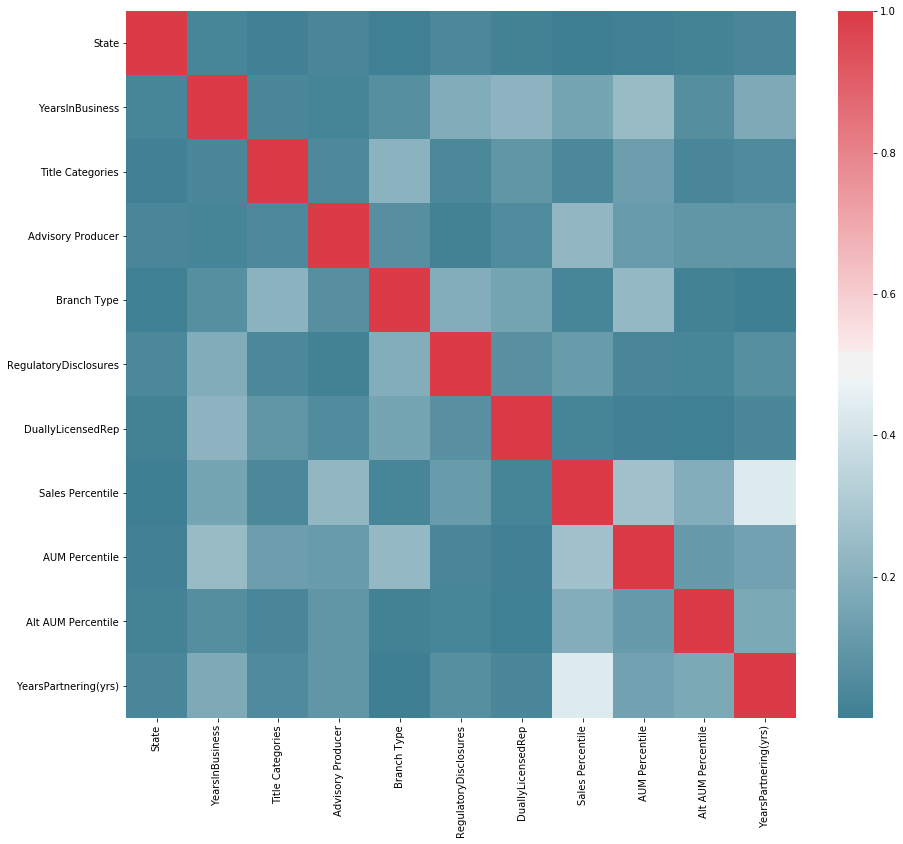

In [7]:
# Aim to reduce features by finding the items which have the 'highest' absolute correlation
corr_matrix = df_rs.corr().abs()
sol = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(15, 13))
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, cmap=color_map)

sol.columns = ['ColName1', 'ColName2', 'AbsCorr']
sol = sol[sol['AbsCorr']>=.4]

# ignore_cols = ['Rep CRD', 'DateOfBirth_Year']

# sol = sol[(~sol['ColName1'].isin(ignore_cols)) & (~sol['ColName2'].isin(ignore_cols))]

# corr_based_features = list(set(sol['ColName1'].values.tolist() + sol['ColName2'].values.tolist()))
# corr_based_features.insert(0, 'Rep CRD')


# df_rs_subset = df_rs[corr_based_features].dropna(how='any', axis=1)
# df_rs_subset.info()



# KMeans Clustering using full data

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics

prediction_df = df_rs
prediction_df = prediction_df.astype(int)


af = KMeans(n_clusters=7)
assigned_clusters = af.fit_predict(prediction_df.values)
print(af.labels_)

print('Estimated number of clusters: %s' % af.n_clusters)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(df_rs_subset[df_rs_subset.columns.tolist()[1:]].values, labels, metric='sqeuclidean'))

[6 4 6 ... 0 3 5]
Estimated number of clusters: 7


In [9]:
cluster_df = pd.DataFrame(np.char.mod('cluster %d', assigned_clusters), columns=['Cluster'])

## Identify feature importance by attempting to predict cluster assignment.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(prediction_df, cluster_df['Cluster'], random_state=123)

rf_clf = RandomForestClassifier()

rf_clf.fit(train_X, train_y)

pred_y = rf_clf.predict(test_X)

print('Random Forest Accuracy Predicting Clusters: %s' % metrics.accuracy_score(y_pred=pred_y, y_true=test_y))
# print('Random Forest AUC Score: %s' % metrics.roc_auc_score(y_score=rf_clf.predict_proba(test_X), y_true=test_y))
print('Feature Imporance:')
feature_importances = pd.DataFrame(rf_clf.feature_importances_ * 100,
                                   index = train_X.columns,
                                    columns=['feature importance (%)']).sort_values('feature importance (%)', ascending=False)
feature_importances

Random Forest Accuracy Predicting Clusters: 0.9849830795262268
Feature Imporance:


C:\ProgramData\Anaconda2\envs\ListManagement\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,feature importance (%)
AUM Percentile,31.739837
Sales Percentile,31.260453
Title Categories,24.054134
Alt AUM Percentile,5.000439
YearsInBusiness,2.365495
YearsPartnering(yrs),2.159369
State,1.400691
Branch Type,1.055043
RegulatoryDisclosures,0.380787
Advisory Producer,0.297959


## Create excel file with Pivot Table

In [12]:
original_df['Clusters'] = assigned_clusters

OUT_PATH = 'c:/USERS/_cmattson/DESKTOP/CLUSTERMATRIX.xlsx'
writer = pd.ExcelWriter(OUT_PATH)
OFF_LIMIT_COLS = ['Rep CRD', 'Clusters']
for col in original_df.columns.tolist():
    if col not in OFF_LIMIT_COLS:
        pd.pivot_table(original_df, values='Rep CRD', index=col, columns='Clusters', aggfunc='count').to_excel(writer, sheet_name=col[:30].replace(':', '').replace('?', ''))
writer.close()

# Clustering attempt using PCA 

In [ ]:
# Perform PCA to reduce dimensionality of data (reducing to 2 components).

from sklearn.decomposition import PCA

pca = PCA(n_components=3).fit(df_rs)

df_rs_pca3d = pca.transform(df_rs)


In [ ]:
# Perform clustering
df_rs_pca2d = df_rs_pca3d.astype(int)


af = KMeans(n_clusters=7)
assigned_clusters = af.fit_predict(df_rs_pca3d)
print(af.labels_)

print('Estimated number of clusters: %s' % af.n_clusters)

## Identify feature importance by attempting to predict cluster assignment

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df_rs_pca3d, cluster_df['Cluster'], random_state=123)

rf_clf = RandomForestClassifier()

rf_clf.fit(train_X, train_y)

pred_y = rf_clf.predict(test_X)

print('Random Forest Accuracy Predicting Clusters: %s' % metrics.accuracy_score(y_pred=pred_y, y_true=test_y))
